In [ ]:
# 내 드라이브에 대한 주소
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [147]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = "/gdrive/My Drive/dacon_news"

train = pd.read_csv(path + "/data/news_train.csv")
test = pd.read_csv(path + "/data/news_test.csv")

In [ ]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [135]:
from konlpy.tag import Mecab
import re
from konlpy.tag import Okt

tokenizer = Okt()

def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null'] #불용어 설정
    tokenizer = Okt() #형태소 분석기 
    token_list = []
    
    for text in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', text) #한글과 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석 
        token = [t for t in token if t not in stopwords or type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다. 
#train['new_article'], okt = text_preprocessing(train['content'])

In [ ]:
train.to_csv("./okt_news_train.csv", index=False,encoding='utf-8-sig' ) # okt를 완성한 dataset 저장

In [ ]:
train

,n_id,date,title,content,ord,info,new_article,end12
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,"['이데일리', '현재', '코스닥', '기관', '억', '순', '매도']",0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,"['실적', '기반', '저가', '에', '매집', '해야', '할', '월', ...",0
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,"['하', '이스', '탁론', '선취', '수수료', '없는', '월', '최저'...",1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,"['종합', '경제', '정보', '미디어', '이데일리', '무단', '전', '...",1
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,"['전국', '적', '인', '소비', '붐', '조성', '에', '기여', '...",0
...,...,...,...,...,...,...,...,...
118740,NEWS01333,20200117,"모나리자, 중원 지분 16.88% 양수 결정",미 FDA 임상3상 허가 임박. 묻고 따블로 갈 바이오 황제주.,48,1,"['미', '임', '상', '상', '허가', '임박', '묻고', '따블', '...",0
118741,NEWS01333,20200117,"모나리자, 중원 지분 16.88% 양수 결정",똑똑해진 소비자..한국도 이젠 소형차 시대,49,1,"['똑똑해진', '소비자', '한국', '도', '이', '젠', '소형차', '시대']",0
118742,NEWS01333,20200117,"모나리자, 중원 지분 16.88% 양수 결정",똑똑해진 소비자..한국도 이젠 소형차 시대,50,1,"['똑똑해진', '소비자', '한국', '도', '이', '젠', '소형차', '시대']",1
118743,NEWS01333,20200117,"모나리자, 중원 지분 16.88% 양수 결정",2020년 한국 TV 2대중 1대 인터넷 연결된다,51,1,"['년', '한국', '대중', '대', '인터넷', '연결', '된다']",1


#ord로만 예측해보기
- 맨 끝 ord는 무조건 0
- 맨끝에서 -1, -2번째 ord가 1일 확률이 높음

In [ ]:
# 맨끝에서 -1, -2번째
train["end12"]=0
for i in range(0,len(train)):
  try:
    if (train["ord"][i+2]==1)or(train["ord"][i+3]==1):
      train["end12"][i]=1
    elif (len(train)-i==3):
      train["end12"][i]=1
  except:
    if (len(train)-i==2):
      train["end12"][i]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


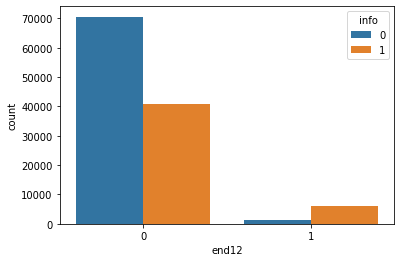

In [ ]:
sns.countplot(x="end12", hue="info", data=train)

In [ ]:
(train.groupby(["end12","info"]).count())

n_id   date  title  content    ord  new_article
end12 info                                                  
0     0     70565  70565  70565    70565  70565        70565
      1     40840  40840  40840    40840  40840        40840
1     0      1248   1248   1248     1248   1248         1248
      1      6092   6092   6092     6092   6092         6092

In [43]:
print("끝에서 1,2번째가 아닐 때 info가 1일 확률 %.3f"%(40840/(70565+40840)))
print("끝에서 1,2번째이면 info가 1일 확률 %.3f"%(6092/(1248+6092)))

끝에서 1,2번째가 아닐 때 info가 1일 확률 0.367
끝에서 1,2번째이면 info가 1일 확률 0.830


In [158]:
train = pd.read_csv("okt_news_train.csv")

#맨 마지막 줄 학습에서 제외

In [ ]:
# 맨 마지막줄은 False인 불리언 배열 반환
def out_endline(data):
  include = [True]*len(data)
  for i in range(len(data)):
    if i+1==len(data):
      include[i]=False
    elif data["ord"][i+1]==1:
      include[i]=False
  return include

In [ ]:
train = train[out_endline(train)]

# Vectorization

In [159]:
all = pd.concat([train,test],axis=0)

In [160]:
train.shape

(118745, 8)

In [161]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=1000):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len) # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']

# train, test 모두 사용
train_X, vocab_size, vectorizer = text2sequence(all['new_article'], max_len = 100)

# train, test 분리
train_X, test_X = train_X[:train.shape[0]], train_X[train.shape[0]:]
print(train_X.shape, train_y.shape)
print(test_X.shape)

vocab_size :  94140
(118745, 100) (118745,)


In [ ]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
path = "/gdrive/My Drive/dacon_news"

In [ ]:
# 구글 word2vec 모델
word2vec = gensim.models.KeyedVectors.load_word2vec_format(path+'/embadding/GoogleNews-vectors-negative300.bin.gz', binary = True)

In [ ]:
# 한국어 word2vec model
word2vec2 = gensim.models.Word2Vec.load('./ko.bin')

In [174]:
# 모두 난수 초기화
np.random.seed(42)
embedding_matrix = np.zeros((vocab_size, 200))
vocab = vectorizer.word_index
count = 0
#vocab = list(map(lambda x: x[1:-1], vocab.keys())) # 불필요한 '' 제거

for idx, word in enumerate(vocab):
    if word in word2vec2:
      embedding_vector = word2vec2[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
      print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass
      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
똑같다면 word2vec에 없는 단어입니다.
만이라도 word2vec에 없는 단어입니다.
회귀분석 word2vec에 없는 단어입니다.
늘어지면 word2vec에 없는 단어입니다.
하겠다기에 word2vec에 없는 단어입니다.
말렸다 word2vec에 없는 단어입니다.
명백하다는 word2vec에 없는 단어입니다.
놀아나겠다고 word2vec에 없는 단어입니다.
산본동 word2vec에 없는 단어입니다.
줄임과 word2vec에 없는 단어입니다.
입고하는 word2vec에 없는 단어입니다.
전남소방 word2vec에 없는 단어입니다.
낮췄으며 word2vec에 없는 단어입니다.
더하는 word2vec에 없는 단어입니다.
기발한 word2vec에 없는 단어입니다.
익살스러운 word2vec에 없는 단어입니다.
phiz word2vec에 없는 단어입니다.
비정부단체 word2vec에 없는 단어입니다.
유성온천역 word2vec에 없는 단어입니다.
시세로 word2vec에 없는 단어입니다.
복잡했던 word2vec에 없는 단어입니다.
책임지겠다는 word2vec에 없는 단어입니다.
끌기에 word2vec에 없는 단어입니다.
체질량지수 word2vec에 없는 단어입니다.
힘쓰겠다는 word2vec에 없는 단어입니다.
동물권 word2vec에 없는 단어입니다.
금당도 word2vec에 없는 단어입니다.
바로잡기 word2vec에 없는 단어입니다.
스럽다면서 word2vec에 없는 단어입니다.
제생 word2vec에 없는 단어입니다.
은반 word2vec에 없는 단어입니다.
차돌박이 word2vec에 없는 단어입니다.
찰기 word2vec에 없는 단어입니다.
직화 word2vec에 없는 단어입니다.
선수권대회 word2vec에 없는 단어입니다.
들여가세요 word2vec에 없는 단어입니다.
맛보세요 word2vec에 없는 단어입니다.
엠아이텍 word2vec에 없는 단어입니다.
치우친다고 word2vec에 없

- 구글것은 한국어 부족, 다른 것을 찾는 것이 필요
- 한국어 전처리 더 필요할듯(~았, ~고, ~었, ~거나, ~지만)
- 영어는 제외?

In [168]:
count

78697

#train test split
- 기사별로 분리?
- 그냥 문장별로 분리?

In [51]:
# 문장별로 train_test set 분리
from sklearn.model_selection import train_test_split

#num_article = len(train["n_id"].unique())
#trainnp.random.randint(0,num_article,int(0.7*num_article))

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 42, test_size = 0.3)

#모델링 비교

1. embedding vector만을 통한 모델링

In [73]:
tf.random.set_seed(42)
from keras import regularizers

In [70]:
# 시퀀셜 LSTM 모델

def LSTM(vocab_size, max_len=1000):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 200,weights = [embedding_matrix], input_length = max_len)) #임베딩 가중치 적용 코드
    model.add(keras.layers.SpatialDropout1D(0.3))
    model.add(keras.layers.LSTM(64))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='selu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()
    return model

In [175]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("hyerim_best_model2.h5",
                                               save_best_only = True)

# 하이퍼파라미터
max_epoch = 5
batch_size = 100

model = LSTM(vocab_size)
history = model.fit(train_X, train_y,epochs=max_epoch,
                 batch_size = batch_size,  validation_batch_size = 100,
                 callbacks = [checkpoint_cb])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 200)         18828000  
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 1000, 200)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 18,900,065
Trainable params: 18,900,065
Non-trainable params: 0
_________________________________________

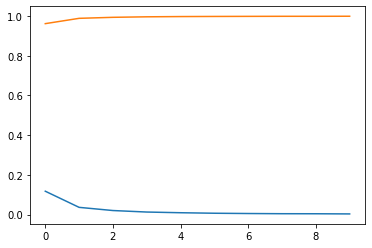

In [176]:
best_model = keras.models.load_model("hyerim_best_model.h5") # 저장된 모델 불러오기
plt.plot(pd.DataFrame(history.history))

In [89]:
best_model.evaluate(train_X, train_y, batch_size = 100)

1151/1151 [==============================] - 71s 61ms/step - loss: 0.0222 - accuracy: 0.9942


[0.02221783809363842, 0.9942202568054199]

In [ ]:
# 데이콘의 평가 accuracy
def dacon_accuracy(target, predicted):
  return 1-np.abs(target-predicted)/len(target)

# submission file 만들기

In [ ]:
model = keras.models.load_model("hyerim_best_model.h5") 

In [179]:
predicted = model.predict(test_X)

In [181]:
np.round(predicted)

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [183]:
submission = pd.read_csv(path+"/data/sample_submission.csv")

In [185]:
submission["info"]=np.round(predicted)

In [186]:
submission.to_csv("hyerim_submission.csv", encoding="utf-8-sig",index=False)